![Python Logo](logo.png)
# New patient analysis  
New patient visits used to be easy to distinguish from those with established patients. ... By CPT definition, a new patient is “one who has not received any professional services from the physician, or another physician of the same specialty who belongs to the same group practice, within the past three years.

**To do:**
1. Load and examine the data set
1. Clean Data
1. Filter CPT Code Range: 99201–99205
1. Number of New Patients by E/M codes
1. Visualize New Patients 
1. Crosstab by gender
1. New patients revenues

Let's begin by importing all required libraries

In [748]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
import csv

%matplotlib inline

## Load and examine the data set
Let's get started. The code shown in the cell below loads the data from the .csv file. Some minimal clean up is performed on the data. 

Execute the code in this cell to load the data into your notebook. **Make sure you have the .csv file in your working directory!**


In [749]:
%%time
url = 'claimdetails2008.csv'
data = pd.read_csv(url, encoding = "latin", low_memory=False, index_col=0)

# Convert date string columns in DataFrames with the .to_datetime() method 
data["dos"] = pd.to_datetime(data["dos"])
data["dob"] = pd.to_datetime(data["dob"])

# Creat year and month series column in a dataframe
data['year'] = pd.DatetimeIndex(data['dos']).year
data['month'] = pd.DatetimeIndex(data['dos']).month
data['day'] = pd.DatetimeIndex(data['dos']).day

CPU times: user 5.74 s, sys: 43.3 ms, total: 5.78 s
Wall time: 5.8 s


### Columns Description:
1. claimid: Claim identification number
1. claimline: Claim line number
1. status: Claim status
1. dos: Data of service
1. cpt_code: CPT Code
1. cpt_desc: CPT Description
1. billedamount: Billed Amount
1. paidamount: Paid Amount by Insurance
1. patientid: Patient Identification number 
1. dob: Patient's date of birth
1. sex: Patient's gender
1. provider: Servicing Provider
1. year: Year of services
1. month: Month of Service
1. day: Day of service
1. insurance
1. city: Patient city
1. state: Patient State
1. zipcode: Patient zipcode

Using the Pandas head method let's have a first look at the columns in this data set.

In [750]:
data.head()

,claimid,claimline,status,dos,cpt_code,cpt_desc,billedamount,paidamount,patientid,dob,sex,city,state,zipcode,provider,insurance,year,month,day
0,CL12933,6,DENIED,2008-04-21,83718,ASSAY OF LIPOPROTEIN,20,0.00,PAT1000,1996-09-17,Female,Warren,MI,48092.0,PROVIDER 1,BCBSM,2008,4,21
1,CL12933,7,PAID,2008-04-21,85014,HEMATOCRIT,15,3.40,PAT1000,1996-09-17,Female,Warren,MI,48092.0,PROVIDER 1,BCBSM,2008,4,21
2,CL12933,2,PAID,2008-04-21,90471,IMMUNIZATION ADMIN,25,24.06,PAT1000,1996-09-17,Female,Warren,MI,48092.0,PROVIDER 1,BCBSM,2008,4,21
3,CL12933,3,PAID,2008-04-21,90472,"IMMUNIZATION ADMIN, EACH ADD",50,13.18,PAT1000,1996-09-17,Female,Warren,MI,48092.0,PROVIDER 1,BCBSM,2008,4,21
4,CL12933,5,PAID,2008-04-21,90734,"MENINGOCOCCAL VACCINE, IM",150,93.87,PAT1000,1996-09-17,Female,Warren,MI,48092.0,PROVIDER 1,BCBSM,2008,4,21


### Data clean up

In [751]:
# examin the empty rows
empty_rows = data[data.isnull().T.any().T]
# Diplay first 5 rows
empty_rows.head()

,claimid,claimline,status,dos,cpt_code,cpt_desc,billedamount,paidamount,patientid,dob,sex,city,state,zipcode,provider,insurance,year,month,day
9896,CL10203,1,DENIED,2008-01-23,99214,"OFFICE/OUTPATIENT VISIT, EST",100,0.0,PAT3986,2002-11-19,Male,Sterling Heights,MI,48314.0,NaN,NaN,2008,1,23
9898,CL10201,1,DENIED,2008-01-23,99214,"OFFICE/OUTPATIENT VISIT, EST",100,0.0,PAT3987,2004-10-26,Female,Sterling Heights,MI,48314.0,NaN,NaN,2008,1,23
11435,CL10003,1,DENIED,2008-01-25,99213,"OFFICE/OUTPATIENT VISIT, EST",75,0.0,PAT43666,2047-04-20,Male,SOUTHFIELD,MI,48076.0,NaN,NaN,2008,1,25
11630,CL15232,2,DENIED,2008-07-03,90471,IMMUNIZATION ADMIN,50,0.0,PAT45401,2034-05-03,Male,W BLOOMFIELD,MI,48322.0,NaN,NaN,2008,7,3
11631,CL15232,3,DENIED,2008-07-03,90472,"IMMUNIZATION ADMIN, EACH ADD",50,0.0,PAT45401,2034-05-03,Male,W BLOOMFIELD,MI,48322.0,NaN,NaN,2008,7,3


In [752]:
# Delete rows with empty values in the data subset
data.dropna(subset=['provider', 'cpt_code', 'patientid', 'sex', 'dob', 'insurance'], how='any', inplace = True)

In [753]:
data.head()

,claimid,claimline,status,dos,cpt_code,cpt_desc,billedamount,paidamount,patientid,dob,sex,city,state,zipcode,provider,insurance,year,month,day
0,CL12933,6,DENIED,2008-04-21,83718,ASSAY OF LIPOPROTEIN,20,0.00,PAT1000,1996-09-17,Female,Warren,MI,48092.0,PROVIDER 1,BCBSM,2008,4,21
1,CL12933,7,PAID,2008-04-21,85014,HEMATOCRIT,15,3.40,PAT1000,1996-09-17,Female,Warren,MI,48092.0,PROVIDER 1,BCBSM,2008,4,21
2,CL12933,2,PAID,2008-04-21,90471,IMMUNIZATION ADMIN,25,24.06,PAT1000,1996-09-17,Female,Warren,MI,48092.0,PROVIDER 1,BCBSM,2008,4,21
3,CL12933,3,PAID,2008-04-21,90472,"IMMUNIZATION ADMIN, EACH ADD",50,13.18,PAT1000,1996-09-17,Female,Warren,MI,48092.0,PROVIDER 1,BCBSM,2008,4,21
4,CL12933,5,PAID,2008-04-21,90734,"MENINGOCOCCAL VACCINE, IM",150,93.87,PAT1000,1996-09-17,Female,Warren,MI,48092.0,PROVIDER 1,BCBSM,2008,4,21


In [754]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24549 entries, 0 to 24565
Data columns (total 19 columns):
claimid         24549 non-null object
claimline       24549 non-null int64
status          24549 non-null object
dos             24549 non-null datetime64[ns]
cpt_code        24549 non-null object
cpt_desc        24549 non-null object
billedamount    24549 non-null int64
paidamount      24549 non-null float64
patientid       24549 non-null object
dob             24549 non-null datetime64[ns]
sex             24549 non-null object
city            24549 non-null object
state           24549 non-null object
zipcode         24549 non-null float64
provider        24549 non-null object
insurance       24549 non-null object
year            24549 non-null int64
month           24549 non-null int64
day             24549 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(5), object(10)
memory usage: 3.7+ MB


## Style function

In [755]:
def color_negative(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: darkorange'` for negative
    strings, black otherwise.
    """
    color = 'darkorange' if val > 0 else 'black'
    return 'color: %s' % color

# s = df.style.applymap(color_negative_red)
# s

### New patients Analysis
** Filter CPT Code Range: 99201–99205**

In [756]:
# load claims with E/M codes
df_new_patients = data[(data.cpt_code >= '99201') & (data.cpt_code<='99205') & (data.provider =='PROVIDER 1')]

**Number of New Patients by E/M codes**

In [757]:
# Group data
df = df_new_patients.groupby('cpt_code')['month'].value_counts().unstack().fillna(0)

# call style function
df.style.applymap(color_negative)

month,1,2,3,4,5,6,7,8,9,10,11,12
cpt_code,,,,,,,,,,,,
99202,0,0,0,0,0,0,0,0,0,0,0,3
99203,0,0,0,0,1,0,0,0,0,0,0,0
99204,27,33,26,22,24,22,26,26,27,30,22,23


### Crosstab 
**Number of New Patients by E/M codes**

In [758]:
df_cross = pd.crosstab(df_new_patients["cpt_code"],df_new_patients["month"],margins=True)
# call style function
df_cross.style.applymap(color_negative)

month,1,2,3,4,5,6,7,8,9,10,11,12,All
cpt_code,,,,,,,,,,,,,
99202,0,0,0,0,0,0,0,0,0,0,0,3,3
99203,0,0,0,0,1,0,0,0,0,0,0,0,1
99204,27,33,26,22,24,22,26,26,27,30,22,23,308
All,27,33,26,22,25,22,26,26,27,30,22,26,312


### Plot line chart

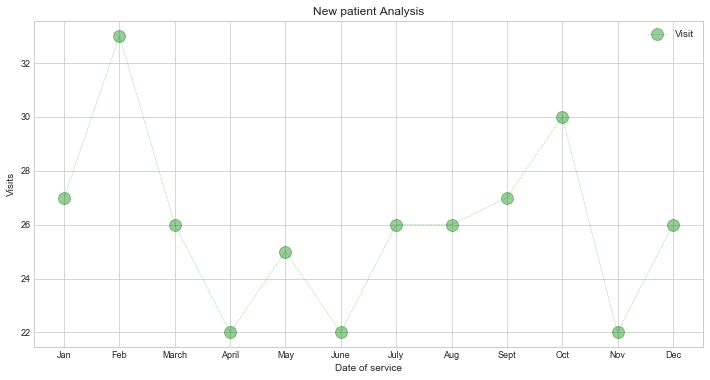

In [759]:
df_visit_month = df_new_patients.groupby(['month'])[["cpt_code"]].count()

df_visit_month.plot(kind = 'line', 
            color='green', 
            grid=True, 
            figsize=(12,6),
            use_index =True,
            fontsize=9,
            sort_columns = True,
            rot=0, 
            marker='o', 
            linestyle='dashed',
            linewidth=.5, 
            markersize=12,
            alpha=0.4)

#  Definition of tick_val and tick_lab
tick_val = [1,2,3,4,5,6,7,8,9,10,11,12]
tick_lab = ['Jan','Feb','March','April','May','June','July','Aug','Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(tick_val, tick_lab)

plt.xlabel('Date of service') # Label x axis
plt.ylabel('Visits') # Label y axis
plt.title('New patient Analysis')
plt.legend(['Visit'])
plt.show()

### Crosstab by gender

In [760]:
df_sex = pd.crosstab(df_new_patients["month"],df_new_patients["sex"],margins=False)

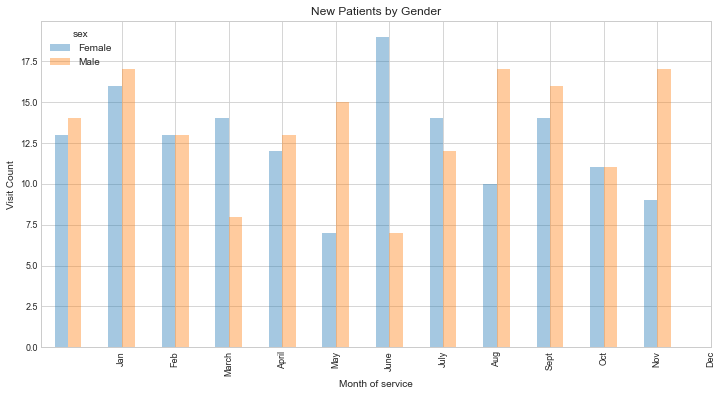

In [761]:
df_sex.plot(kind = 'bar',
                     grid=True, 
                     figsize=(12,6),
                     use_index =True,
                     fontsize=9,
                     sort_columns = True,
                    alpha=0.4)

#  Definition of tick_val and tick_lab
tick_val = [1,2,3,4,5,6,7,8,9,10,11,12]
tick_lab = ['Jan','Feb','March','April','May','June','July','Aug','Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(tick_val, tick_lab)

plt.xlabel('Month of service') # Label x axis
plt.ylabel('Visit Count') # Label y axis
plt.title('New Patients by Gender')
plt.show()

### New patients revenues

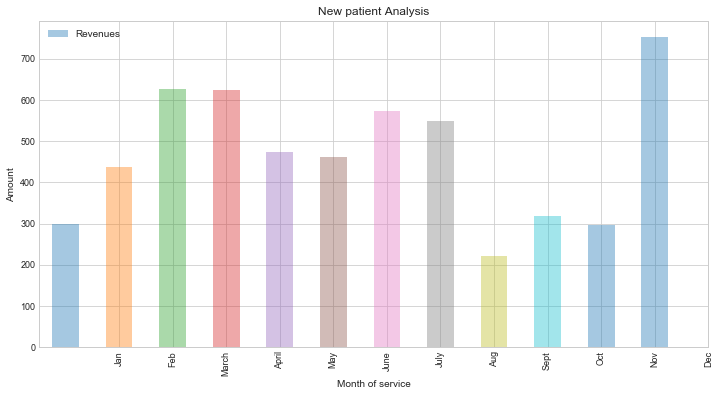

In [762]:
df_revenues = df_new_patients.groupby('month')['paidamount'].sum()
df_revenues.plot(kind = 'bar', 
            grid=True, 
            figsize=(12,6),
            use_index =True,
            fontsize=9,
            sort_columns = True,
            alpha=0.4)

#  Definition of tick_val and tick_lab
tick_val = [1,2,3,4,5,6,7,8,9,10,11,12]
tick_lab = ['Jan','Feb','March','April','May','June','July','Aug','Sept', 'Oct', 'Nov', 'Dec']
plt.xticks(tick_val, tick_lab)

plt.xlabel('Month of service') # Label x axis
plt.ylabel('Amount') # Label y axis
plt.title('New patient Analysis')
plt.legend(['Revenues'])
plt.show()

### end of report